# Day 2, session 2: Extracting signal tracks from contact matrices

In this session we will extract biologically relevant signal tracks from contact matrices.
We will be working with published data from [Bonev et al. 2017](https://doi.org/10.1016/j.cell.2017.09.043).
We have 2 cool files at 5kb resolution:

* mouse Embryonic stem cells (mESC)
* Neuroprogenitor cells (NPC)

Here, we will be comparing these two stages of differentiation using different features extracted from contact maps.

## Multiresolution files

The cool files provided are at 5kb resolution. There is a trade-off when choosing a resolution for Hi-C contact maps. The higher resolution, the more details can be seen, however this also reduces the contrast, especially at longer ranges. This is visible by eye: At high resolutions, contacts quickly drop to near-zero values when going away from the diagonal. 

Depending on the coverage and signal we are interested in, we might need to use different resolutions. For example, short range signals like TADs or chromatin loops are analysed easily at high resolutions (e.g. 5-10kb), whereas compartments often require using lower resolutions (e.g. 50-100kb).

Fortunately, the cooler API offers a command to quickly generate cool files at multiple-resolutions. These files are called "mcool" files.

In [ ]:
%%bash
cooler zoomify -r 10000,20000,50000,100000 --balance input.cool -o output.mcool

The resulting mcool file will actually contain multiple cool files withing its tree hierarchy. you can inspect it using `cooler tree output.mcool`. You should see a root note named `/resolutions` with children whose name is the resolution (e.g. `10000`). This path within the tree is named the URI any cool within a mcool can be accessed using its URI. The file path and URI are separated using `::/`. For example, to show a region of the matrix at 50kb resolution:

```bash
cooler show output.mcool::/resolutions/50000 'chr1:3000000-6000000'
```

Similarly, to access it from the python API:

In [1]:
import cooler
clr = cooler.Cooler('data/output.mcool::/resolutions/50000')

## Insulation score

Insulation scores is used by many methods to measure a "border score". Insulation measures the depletion of contacts across a position, which is typically the case at TAD borders.

To compute insulation, we slide a "diamond" along the diagonal, with the diamond corner touching the diagonal. Here is a basic implementation to understand the concept:

In [26]:
import numpy as np

def insulation(mat, win_size=10):
    score = np.nan * np.ones(mat.shape[0])
    for i in range(0, mat.shape[0]):
        lo = max(0, i + 1 - win_size)
        hi = min(i + win_size, mat.shape[0])
        score[i] = np.nanmean(mat[lo : i + 1, i:hi])
    score /= np.median(score)
    return score

<IPython.core.display.Javascript object>


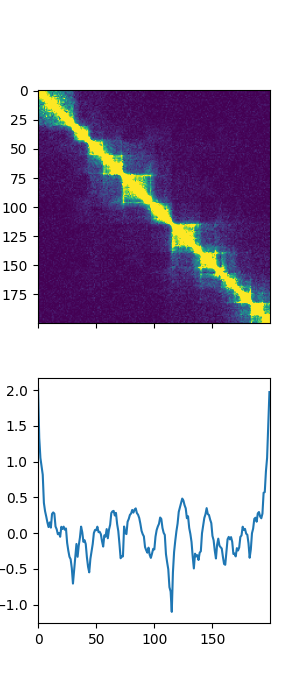

In [86]:
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.sparse as sp
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3, 7))
mat = clr.matrix(balance=True).fetch('chr1:8000000-18000000')
ax[0].imshow(mat, vmax=np.percentile(mat, 95))
ax[1].plot(np.log2(insulation(mat, win_size=10)))

Fortunately, this is already implemented in some packages such as cooltools:

In [ ]:
cooltools diamond-insulation output.mcool::/resolutions/10000 100000

> What is the consequence of changing the window size ?

> How would you choose a window size ?

> What are the main differences between insulation scores of NPC and mESC ?

In [76]:
# Region around sox2
region = "chr3:32,650,405-36,652,461"
# region = "chr8:10,395,295-14,400,126"
mesc = cooler.Cooler('data/4DNFI9FPCAC7_G0G1_mESC_sub.cool')
npc = cooler.Cooler('data/4DNFIEB68WXR_G0G1_NPC_sub.cool')

<IPython.core.display.Javascript object>


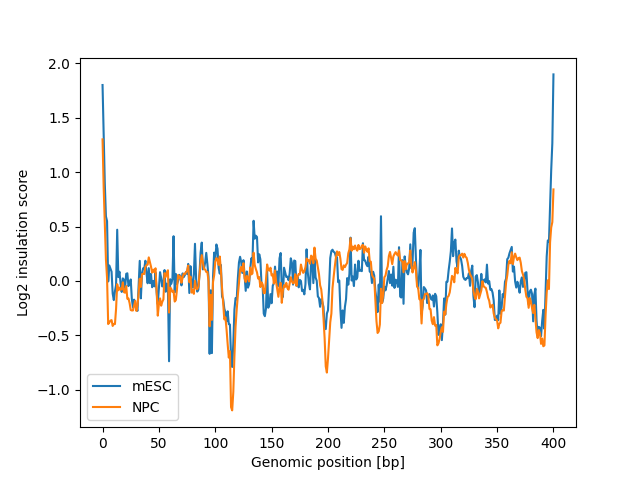

Text(0, 0.5, 'Log2 insulation score')

In [77]:
%matplotlib notebook
plt.plot(np.log2(insulation(mesc.matrix(balance=True).fetch(region))), label='mESC')
plt.plot(np.log2(insulation(npc.matrix(balance=True).fetch(region))), label='NPC')
plt.legend()
plt.xlabel('Genomic position [bp]')
plt.ylabel('Log2 insulation score')

<IPython.core.display.Javascript object>


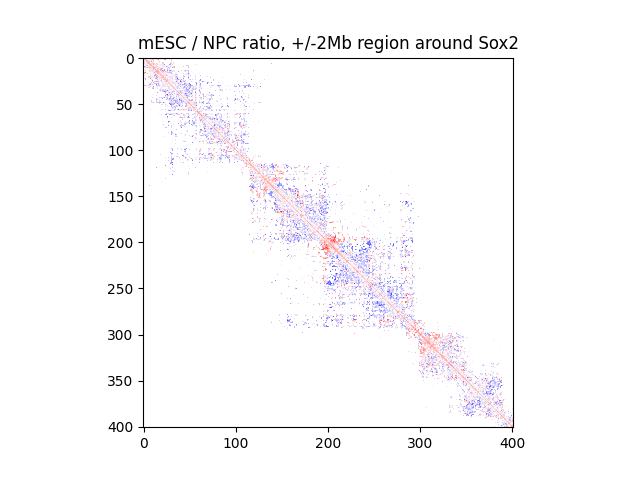

/home/cyril/.local/share/anaconda3/envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cyril/.local/share/anaconda3/envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cyril/.local/share/anaconda3/envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
%matplotlib notebook
plt.title('mESC / NPC ratio, +/-2Mb region around Sox2')
plt.imshow(np.log2(mesc.matrix(balance=False).fetch(region)/npc.matrix(balance=False).fetch(region)), cmap='bwr')

### Note: Cleaner ratios

Matrix ratios are usually noisy and hard to read, especially at longer ranges, where the signal to noise ratio is lower. Some methods like binless and serpentine attempt to adress this issue with adaptative binning . Below is a visualisation of the previous ratio compared to to the serpentine version.

The general idea of these techniques is to use larger pixels where contact values are smaller.
Official serpentine documentation: https://serpentine.readthedocs.io

<IPython.core.display.Javascript object>


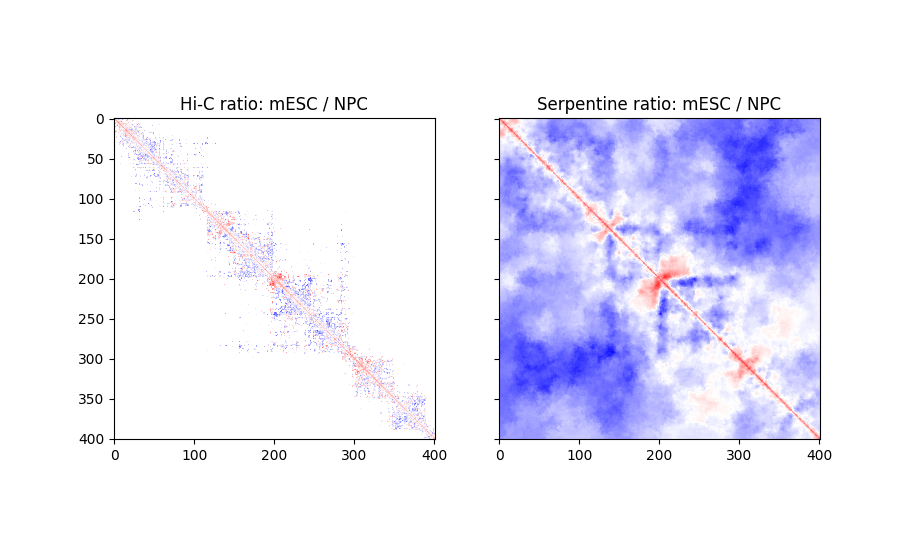

/home/cyril/.local/share/anaconda3/envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/cyril/.local/share/anaconda3/envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/cyril/.local/share/anaconda3/envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log2
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Serpentine ratio: mESC / NPC')

In [83]:
%matplotlib notebook
from serpentine import serpentin_binning

A = np.nan_to_num(mesc.matrix(balance=False).fetch(region), 0)
B = np.nan_to_num(npc.matrix(balance=False).fetch(region), 0)

sA, sB, sK = serpentin_binning(B,A,parallel=1,verbose=False,)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].imshow(np.log2(A/B), cmap='bwr')
ax[1].imshow(sK - np.median(sK), cmap='bwr')
ax[0].set_title('Hi-C ratio: mESC / NPC')
ax[1].set_title('Serpentine ratio: mESC / NPC')

## A/B Compartments

A/B compartments reflect types of chromatin (euchromatin / heterochromatin) which are isolated from each other. These compartments form characterstic "plaid" like patterns on Hi-C maps. The compartments coordinates can be extracted using PCA on detrended intrachromosomal matrices.

Since compartments are long range interactions, it is often better to use a lower resolution.

In [109]:
from sklearn.decomposition import PCA
from chromosight.utils.preprocessing import detrend
clr = cooler.Cooler('data/output.mcool::/resolutions/50000')
mat = clr.matrix(balance=True).fetch('chr2')
mat = np.nan_to_num(mat, 0)
mat = detrend(sp.csr_matrix(mat)).toarray()
pca = PCA(n_components=100)
pcs_df = pca.fit_transform(mat)


/home/cyril/.local/share/anaconda3/envs/r_env/lib/python3.7/site-packages/chromosight/utils/preprocessing.py:188: RuntimeWarning: Mean of empty slice
  dist[diag] = fun(detect_diag[detect_diag > 0])


<IPython.core.display.Javascript object>


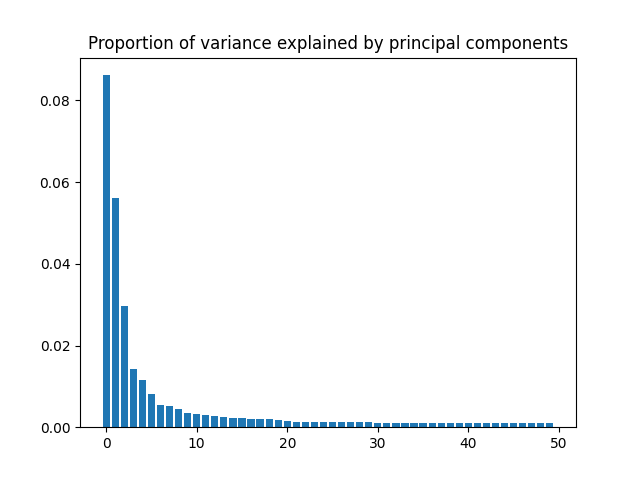

Text(0.5, 1.0, 'Proportion of variance explained by principal components')

In [110]:
%matplotlib notebook
plt.bar(range(50), height=pca.explained_variance_ratio_[:50])
plt.title('Proportion of variance explained by principal components')

In [104]:
%matplotlib notebook
plt.imshow(pca.inverse_transform(pcs_df[:, :2]))

ValueError: shapes (3643,2) and (3643,3643) not aligned: 2 (dim 1) != 3643 (dim 0)

In [112]:
pcs_df

array([[ 1.13714565e+00, -5.64669235e+00, -6.08485474e+00, ...,
         9.15890438e-03, -7.44835072e-04, -8.19576282e-04],
       [ 1.13714565e+00, -5.64669235e+00, -6.08485474e+00, ...,
         9.15890438e-03, -7.44835073e-04, -8.19576282e-04],
       [ 1.13714565e+00, -5.64669235e+00, -6.08485474e+00, ...,
         9.15890438e-03, -7.44835073e-04, -8.19576282e-04],
       ...,
       [ 1.13714565e+00, -5.64669235e+00, -6.08485474e+00, ...,
         9.15890438e-03, -7.44835073e-04, -8.19576282e-04],
       [ 1.13714565e+00, -5.64669235e+00, -6.08485474e+00, ...,
         9.15890438e-03, -7.44835073e-04, -8.19576282e-04],
       [ 1.13714565e+00, -5.64669235e+00, -6.08485474e+00, ...,
         9.15890438e-03, -7.44835073e-04, -8.19576282e-04]])

> What changes when using the non-detrended Hi-C matrix (diagonal gradient still present) ?


Below is a more convenient implementation using cooltool's helper functions:

In [ ]:
from cooltools.eigdecomp import cooler_cis_eig
lam, eig = cooler_cis_eig(
        clrs[cond],
        bins,
        n_eigs=3,
        phasing_track_col='GC',
        sort_metric='var_explained'
)


In certain situations, the compartment signal is not in the first eigenvector (E1) due to other interfering signal:

* When chromosomal arms are highly insulated, E1 can contain the left/right arm information. Doing PCA on each arm independently (treating them as separate chromosomes) solves the issue.
* In noisy datasets such a cancerous cell lines with many structural variants, the compartment signal sometimes ends up in E2 or even E3. This is why sorting eigenvectors by their correlation with an external signal is important.

## Saddle plots

Saddle plots are a way to visually represent the intensity of the compartment signal.

The eigenvectors are digitized into quantiles (e.g. 10% quantiles), and the average interaction between each combination of quantiles is computed. These averages are then plotted as a 2D heatmap where rows and columns are sorted according to the quantiles.

More details and explanations on saddle plots on the official documentation: https://cooltools.readthedocs.io/en/latest/notebooks/04_saddle-plots.html

In [ ]:
import cooltools

S, C = cooltools.saddle.make_saddle(
    getmatrix,
    group_E1_bounds,
    (digitized, 'E1' + '.d'),
    contact_type='cis')

## Correlation with gene expression

